In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import os

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.agents.dca_agent import DCAAgentTerminate
from agentfil import constants
from mechafil import minting, sim

import numpyro

In [3]:
NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

simulation_start_date = datetime.today().date() - timedelta(days=2)
forecast_length = 1*365
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 1
agent_power_distributions = distribute_agent_power_geometric_series(num_agents, a=0.35)

auth_token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

print('Simulation Start:', simulation_start_date)

Simulation Start: 2023-05-31


In [4]:
agent_types = [DCAAgentTerminate] * num_agents
agent_kwargs_vec = []
random_seed_base=1000
rng = np.random.RandomState(random_seed_base)

mean_pow = 6  # 6 PiB/day of RBP
renewal_rate = 0.8
fil_plus_rate = 0.8
terminate_date = date(2023,11,1)
for ii in range(num_agents):
    kwargs = {
        'max_daily_rb_onboard_pib': mean_pow,
        'renewal_rate': renewal_rate,
        'fil_plus_rate': fil_plus_rate,
        'sector_duration': 360,
        'terminate_date': terminate_date,
    }
    agent_kwargs_vec.append(kwargs)

rewards_per_sector_process_kwargs = {
    'forecast_history': 180,
    'update_every_days': 20000,
    'num_warmup_mcmc': 500,
    'num_samples_mcmc': 500,
    'seasonality_mcmc': 1000,
    'num_chains_mcmc': 2,
    'verbose': False,
    'keep_previous_predictions': False,
    'keep_power_predictions': False,   # Setting this to true enables debugging plots but slows down simulation
}
price_process_kwargs = {
    'forecast_num_mc':1000,
    'random_seed':1234
}

filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               spacescope_cfg=auth_token,
                               agent_types=agent_types, agent_kwargs_list=agent_kwargs_vec, 
                               agent_power_distributions=agent_power_distributions,
                               compute_cs_from_networkdatastart=True, use_historical_gas=True,
                               price_process_kwargs=price_process_kwargs,
                               rewards_per_sector_process_kwargs=rewards_per_sector_process_kwargs,
                               renewals_setting='optimistic',
                              )

/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[


setting scheduled_pledge_release for dates: 2021-03-15 to 2024-05-29


/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:170: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  date_df = df[df["date"] >= pd.to_datetime(date, utc="UTC")]


seeding agent 0 with power pct 1.0
Fast forwarding power to simulation start date... 2023-05-31
Computing Scheduled Expirations from:  2023-05-31  to:  2024-05-29
Initializing circulating supply...
Updating circulating supply statistics...
Updating circulating supply statistics... --> start_date: 2021-03-16
Finished updating CS.  Final date -> 2023-05-30


/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[


In [5]:
sim_len = (end_date - simulation_start_date).days
for ii in tqdm(range(sim_len)):
    filecoin_model.step()

  0%|          | 0/365 [00:00<?, ?it/s]

In [6]:
filecoin_model.agents[0]['agent'].agent_info_df

,date,cc_onboarded,cc_renewed,cc_onboarded_duration,cc_renewed_duration,cum_cc_onboarded,cum_cc_renewed,cum_cc_sched_expire,cum_cc_terminated,deal_onboarded,deal_renewed,deal_onboarded_duration,deal_renewed_duration,cum_deal_onboarded,cum_deal_renewed,cum_deal_sched_expire,cum_deal_terminated
0,2021-03-15,0,0.0,0,0,3360.117645,0.000000,0.000000,0.000000,0.0,0.0,0,0,3361.080963,0.000000,0.000000,0.000000
1,2021-03-16,0,0.0,0,0,3390.869476,0.000000,0.000305,0.000549,0.0,0.0,0,0,3391.859123,0.000000,0.000305,0.000549
2,2021-03-17,0,0.0,0,0,3422.715179,0.000000,0.000366,0.000641,0.0,0.0,0,0,3423.714043,0.000000,0.000366,0.000641
3,2021-03-18,0,0.0,0,0,3454.144684,0.000000,0.000397,0.000671,0.0,0.0,0,0,3455.178173,0.000000,0.000397,0.000671
4,2021-03-19,0,0.0,0,0,3485.528687,0.000000,0.000427,0.000885,0.0,0.0,0,0,3486.632321,0.000000,0.000427,0.000885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,2024-05-25,0,0.0,0,0,23666.424774,21315.524384,37256.616394,6526.162170,0.0,0.0,0,0,39311.754385,21888.035931,41930.146328,6530.922653
1168,2024-05-26,0,0.0,0,0,23666.424774,21315.524384,37311.798773,6526.162170,0.0,0.0,0,0,39311.754385,21888.035931,42061.080908,6530.922653
1169,2024-05-27,0,0.0,0,0,23666.424774,21315.524384,37356.942084,6526.162170,0.0,0.0,0,0,39311.754385,21888.035931,42169.588554,6530.922653
1170,2024-05-28,0,0.0,0,0,23666.424774,21315.524384,37427.917682,6526.162170,0.0,0.0,0,0,39311.754385,21888.035931,42319.042683,6530.922653


In [7]:
forecasts_df = filecoin_model.global_forecast_df
update_dates = filecoin_model.minting_process.update_dates
model_df = filecoin_model.filecoin_df
model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_41695/1742197849.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]


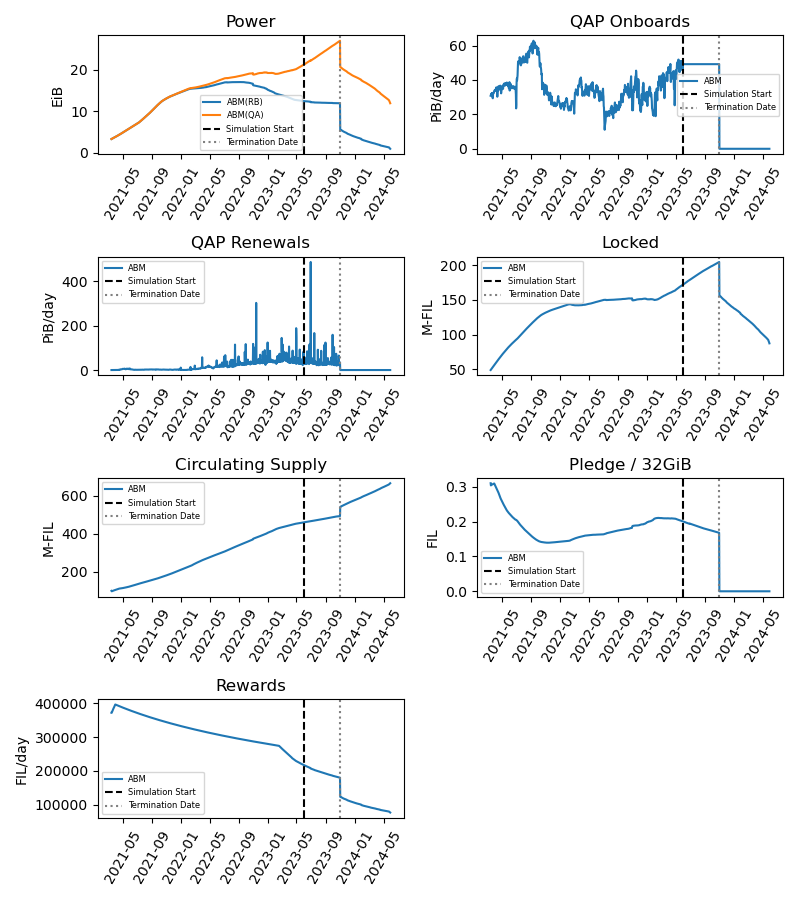

In [8]:
plt.figure(figsize=(8,9))
plt.subplot(4,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='ABM(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='ABM(QA)')
# plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('Power')

plt.subplot(4,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='ABM')
# plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'] - mechafil_df['day_onboarded_power_QAP']/PIB, 
#          label='Onboarded[ABM-MechaFIL]')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=60)
plt.title('QAP Onboards')
plt.ylabel('PiB/day')
plt.legend(fontsize=6)

plt.subplot(4,2,3)
plt.plot(model_df['date'], model_df['day_renewed_qap_pib'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=60)
plt.title('QAP Renewals')
plt.ylabel('PiB/day')
plt.legend(fontsize=6)

plt.subplot(4,2,4)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')
plt.legend(fontsize=6)

plt.subplot(4,2,5)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.legend(fontsize=6)

plt.subplot(4,2,6)
plt.plot(model_df['date'].iloc[1:], model_df['day_pledge_per_QAP'].iloc[1:], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('FIL')
plt.xticks(rotation=60)
plt.title('Pledge / 32GiB')
plt.legend(fontsize=6)

plt.subplot(4,2,7)
plt.plot(model_df['date'], model_df['day_network_reward'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('FIL/day')
plt.xticks(rotation=60)
plt.title('Rewards')
plt.legend(fontsize=6)

plt.tight_layout()

plt.show()
# plt.savefig(os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'abm', 'NO_renew_deal_sectors.png'))